In [140]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from skimage.data import imread
from skimage.io import imshow
from skimage.feature import corner_harris, corner_peaks

from scipy.signal import gaussian
from scipy.signal import convolve2d

In [602]:
# Constants :
kappa = 0.05
sigma_d = 1
sigma_i = 2
threshold = 0.1

# Theoritical results

   ## chesboard

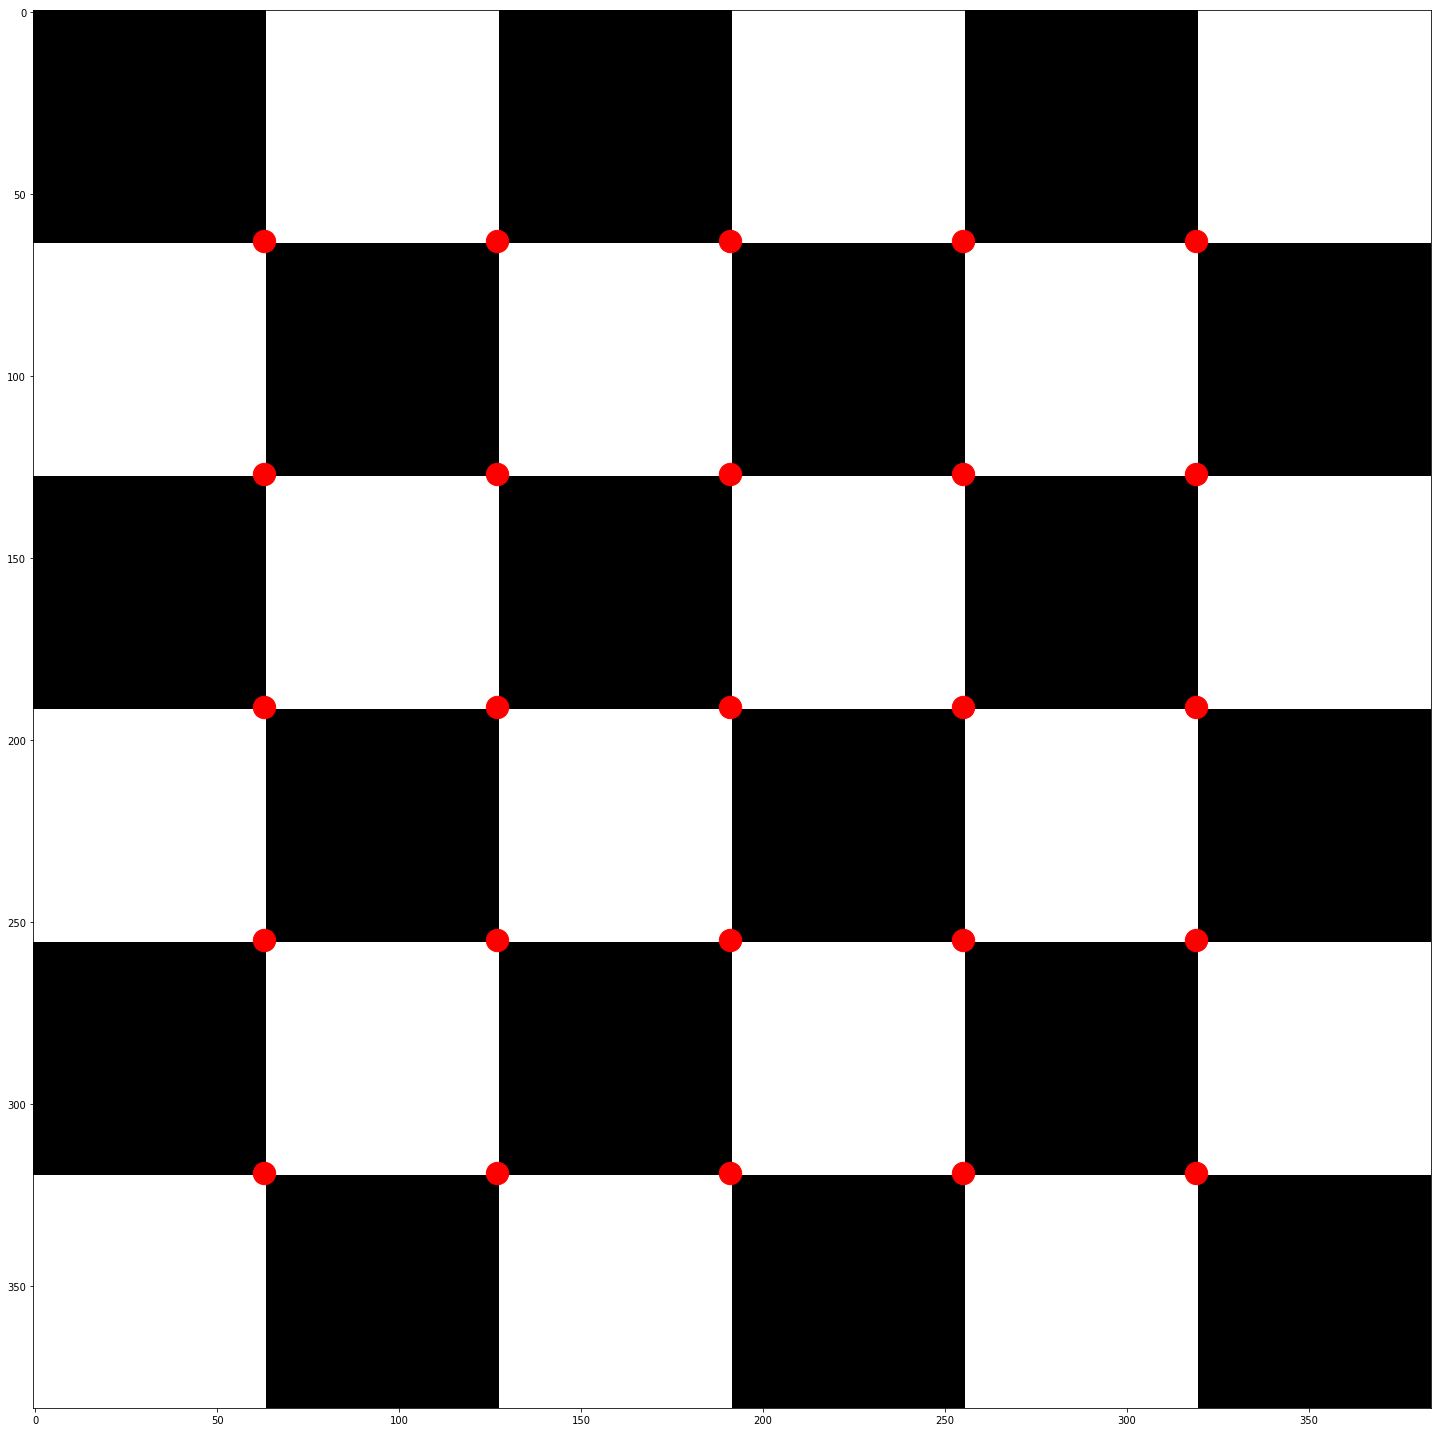

In [703]:
chessboard = imread('images/checkerboard.png')
chess_th = corner_peaks(corner_harris(chessboard), min_distance = 5);
plt.figure(figsize = (20, 20));
plt.scatter(chess_th[:, 0], chess_th[:, 1], color = 'r', marker= ".", s = 2000);
imshow(chessboard);

## bouc.pgm

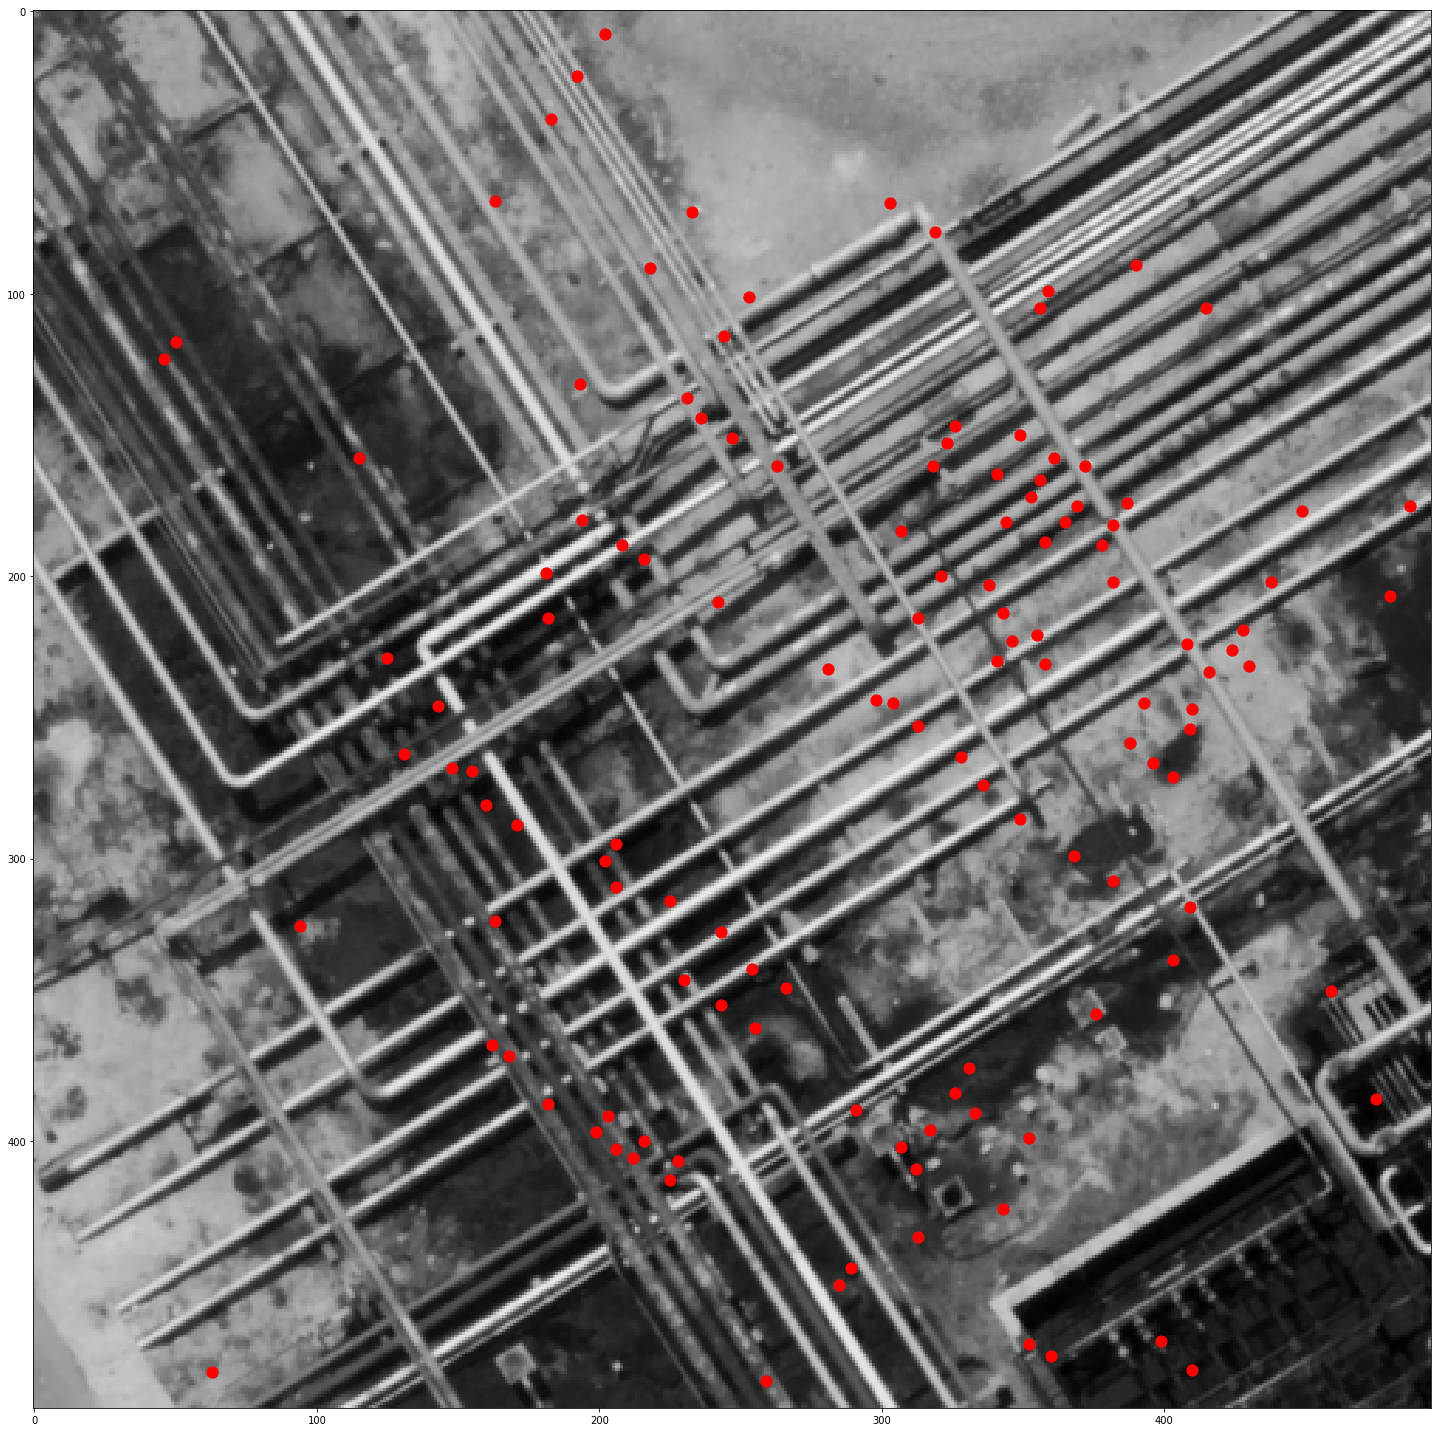

In [571]:
bouc = imread('images/bouc.pgm')
theorical = corner_peaks(corner_harris(bouc), min_distance = 5);
plt.figure(figsize = (20, 20));
plt.scatter(theorical[:, 0], theorical[:, 1], color = 'r', marker= ".", s = 500);
imshow(bouc);

# Practical session

In [572]:
theorical.shape

(130, 2)

In [668]:
bouc = chessboard

In [669]:
# Size of image
bouc.shape

(384, 384)

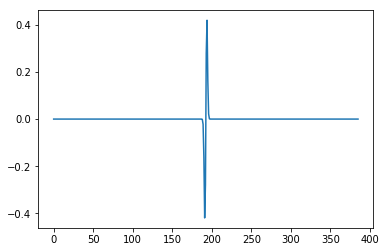

In [670]:
dx = [-0.5, 0, 0.5]

G = np.convolve(gaussian(bouc.shape[0], std = sigma_d), dx);
plt.plot(G);

In [671]:
Gx = G.reshape(1, -1)
Gy = Gx.T
Gxy = Gy.dot(Gx)

print ("Shape of Gx : {} and Gy : {}".format(Gx.shape, Gy.shape))

Shape of Gx : (1, 386) and Gy : (386, 1)


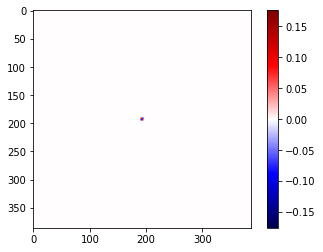

In [672]:
plt.imshow(Gxy, cmap = 'seismic');
plt.colorbar();

In [673]:
Ix = convolve2d(bouc, Gx, mode = 'same')
Iy = convolve2d(bouc, Gy, mode = 'same')

In [674]:
print ("Shape of Ix : {} and Iy : {}".format(Ix.shape, Iy.shape))

Shape of Ix : (384, 384) and Iy : (384, 384)


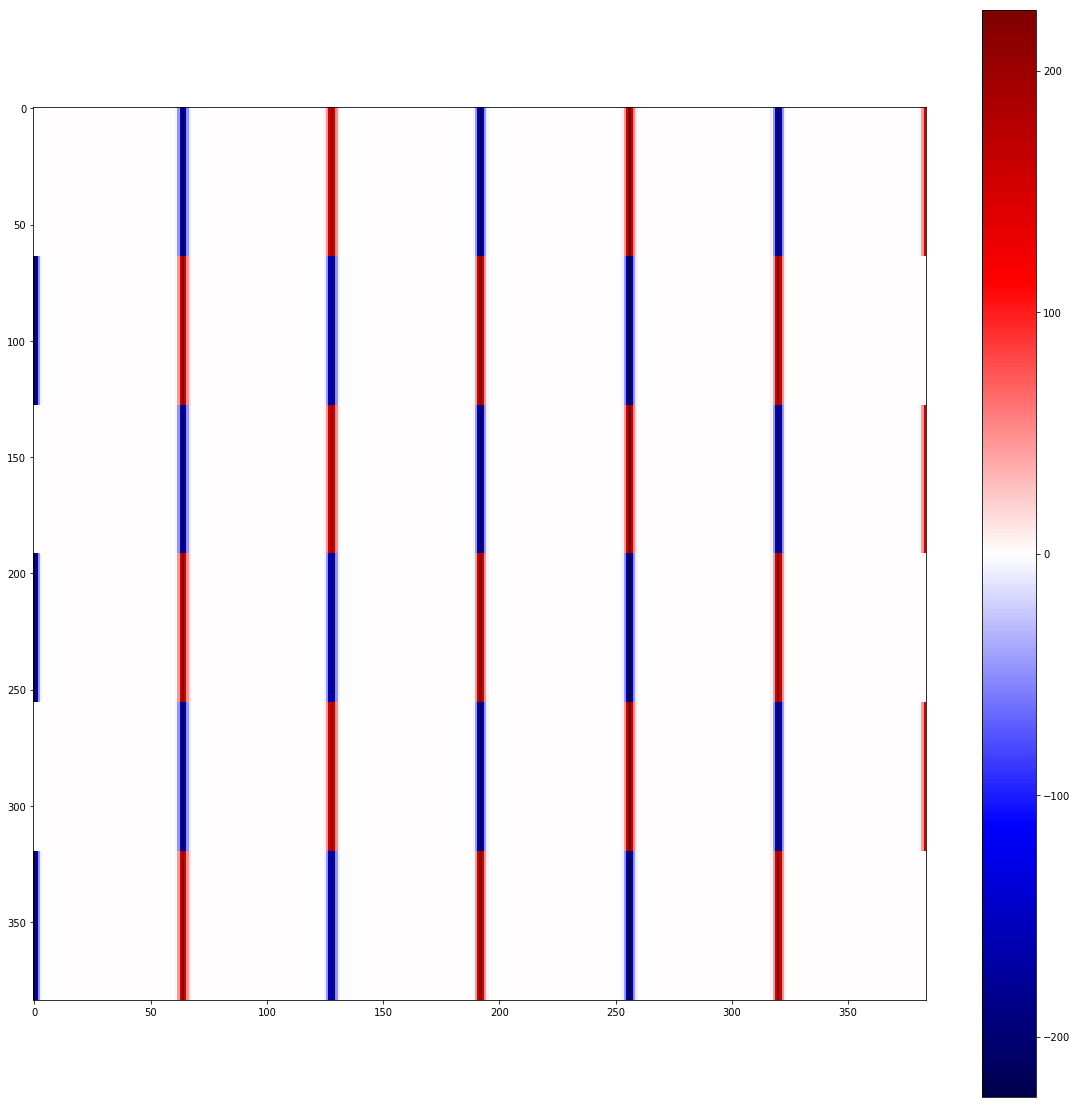

In [675]:
plt.figure(figsize = (20, 20));
plt.imshow(Ix, cmap = "seismic"); plt.colorbar();

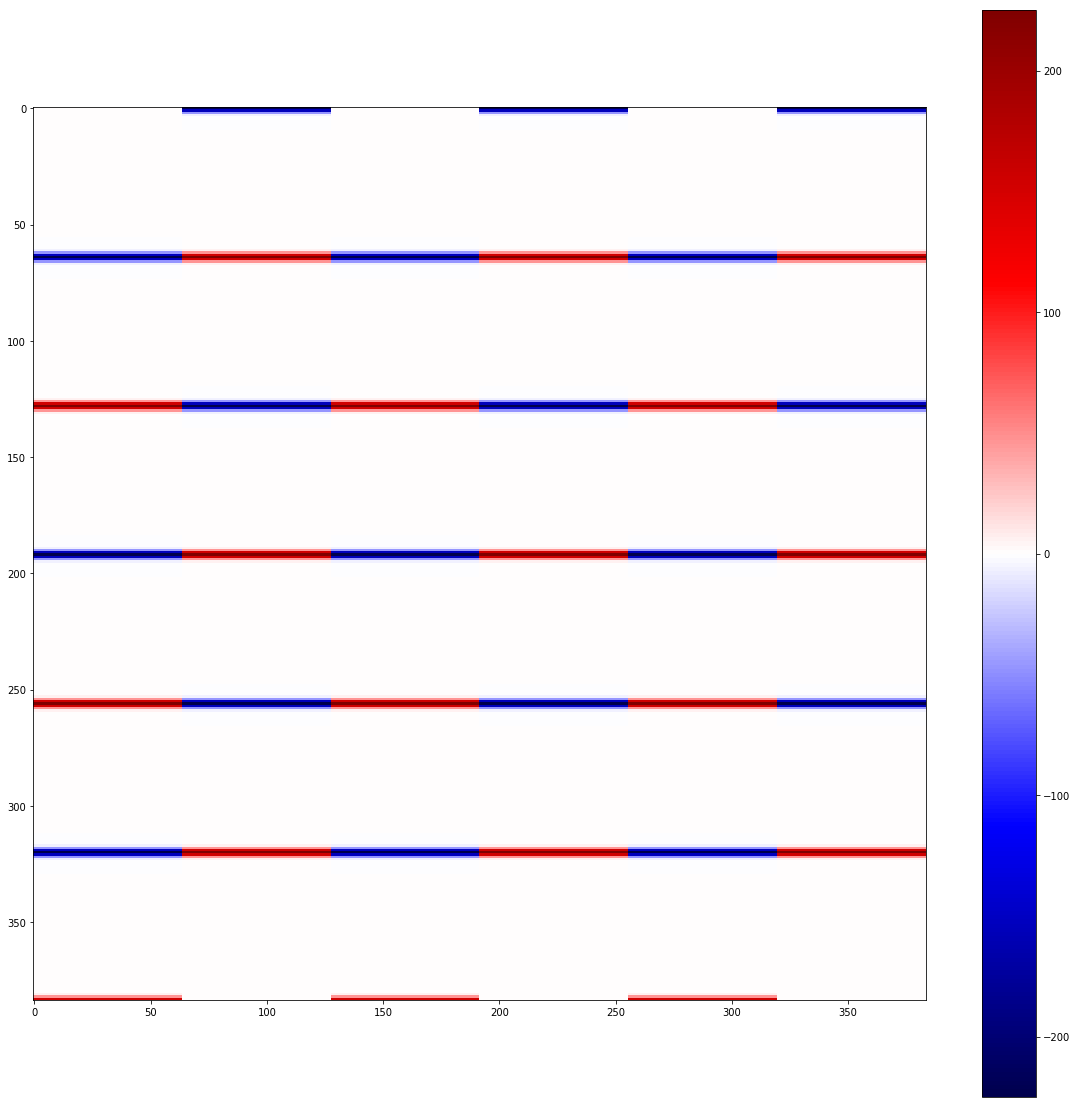

In [676]:
plt.figure(figsize = (20, 20));
plt.imshow(Iy, cmap = "seismic"); plt.colorbar();

# Product images

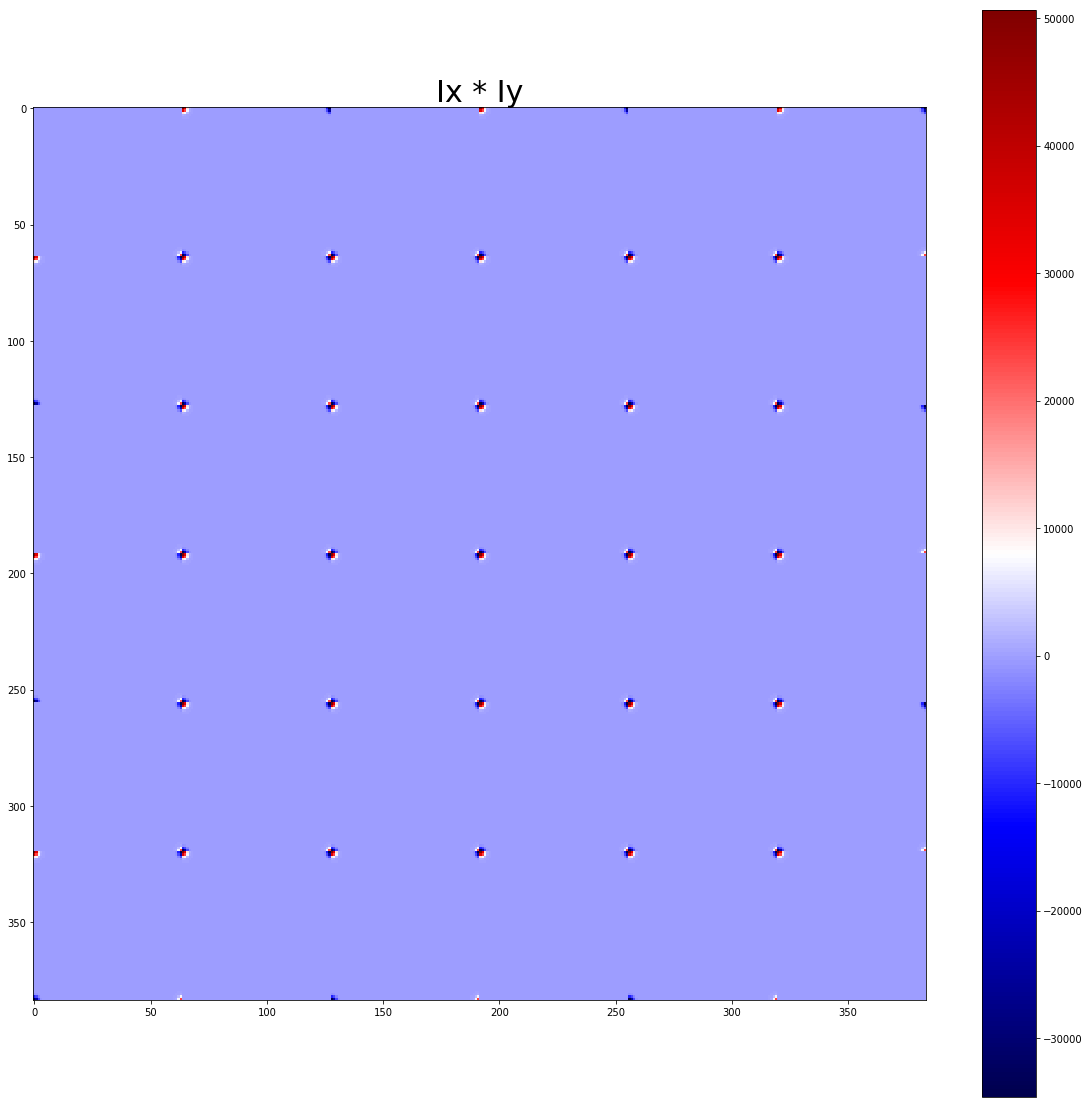

In [677]:
plt.figure(figsize = (20, 20));
plt.imshow(Ix * Iy, cmap = "seismic"); plt.colorbar();
plt.title("Ix * Iy", fontsize = 30);

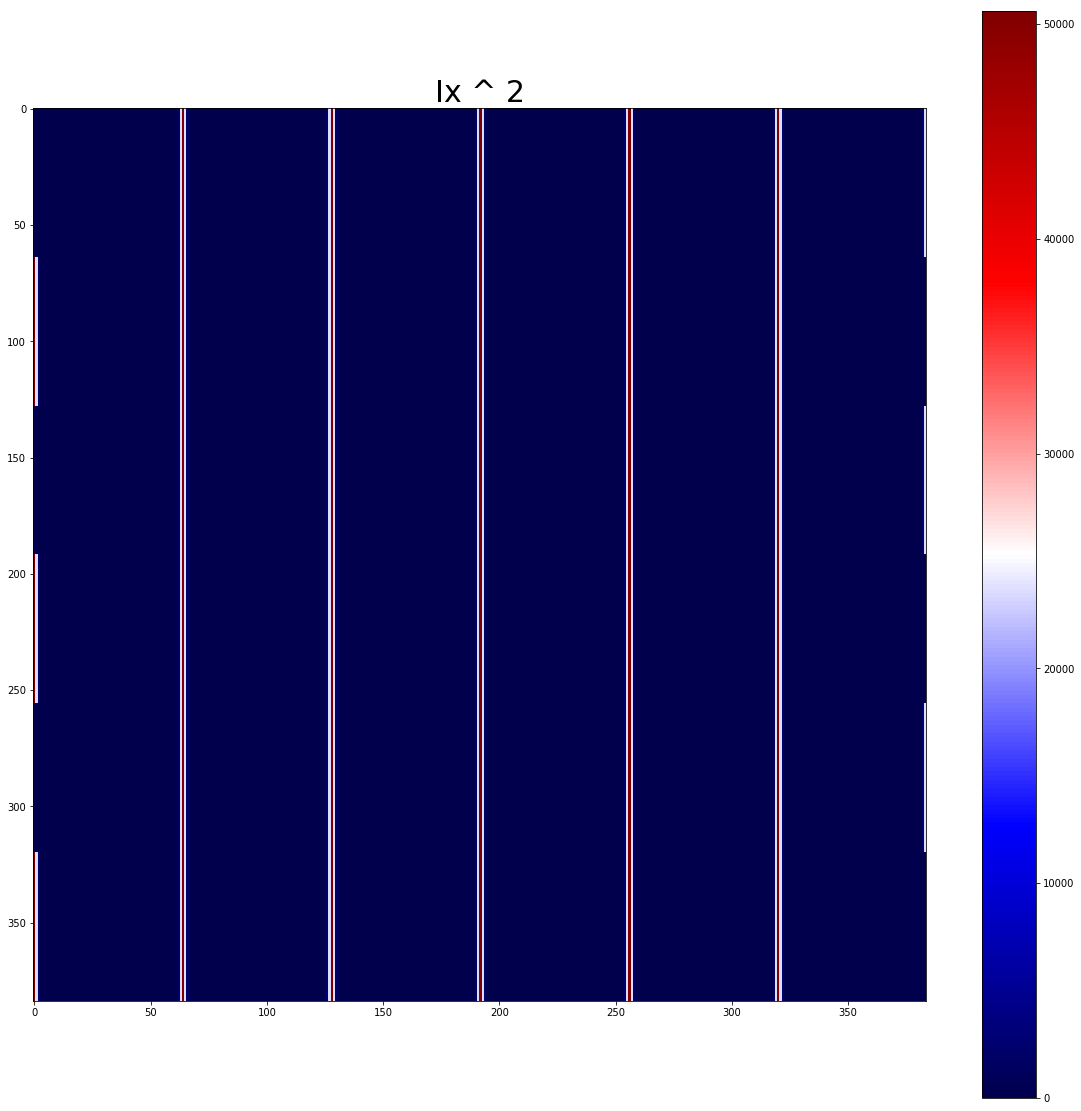

In [678]:
plt.figure(figsize = (20, 20));
plt.imshow(Ix ** 2, cmap = "seismic"); plt.colorbar();
plt.title("Ix ^ 2", fontsize = 30);

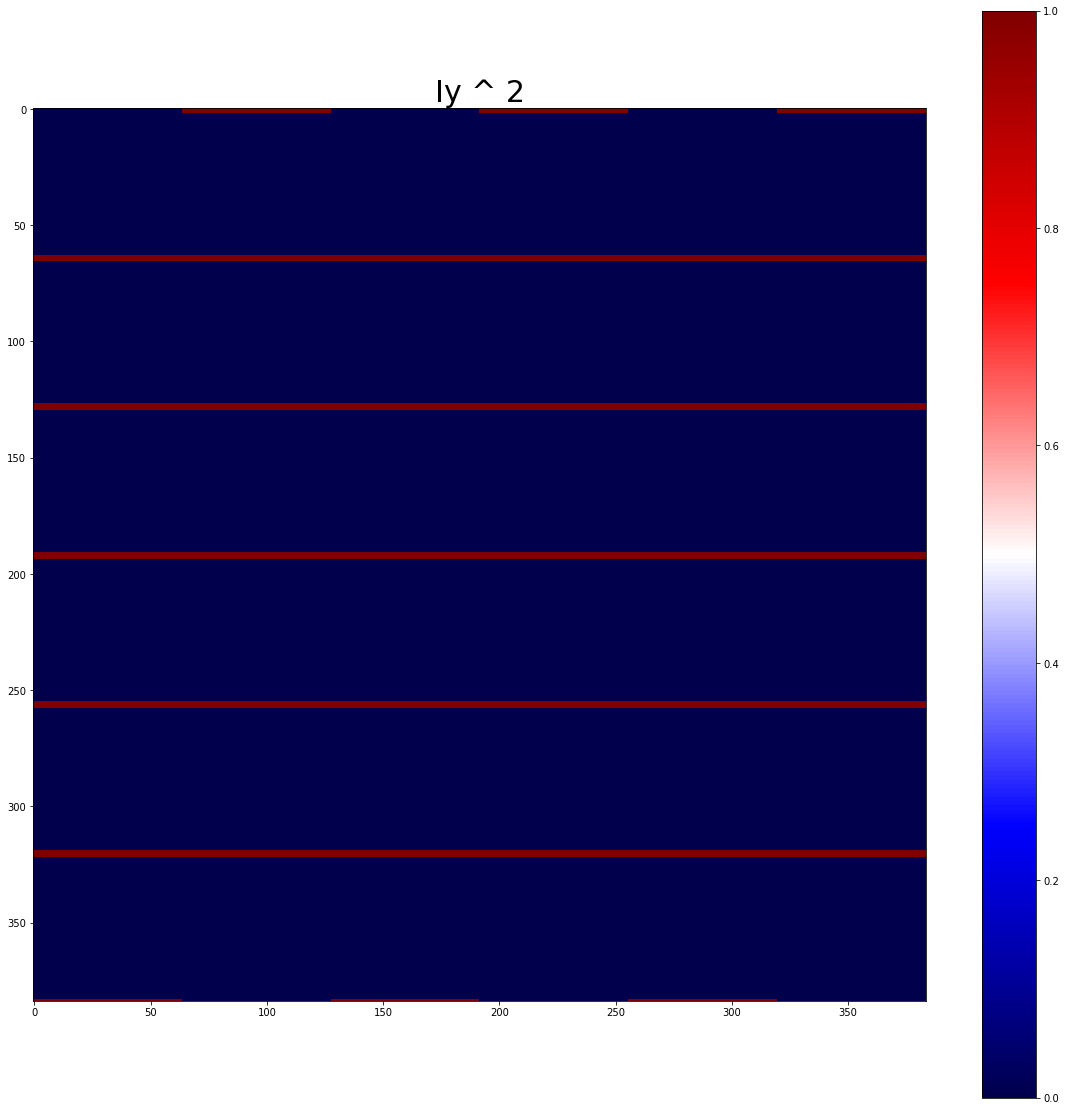

In [679]:
plt.figure(figsize = (20, 20));
plt.imshow(Iy ** 2 > 10000, cmap = "seismic"); plt.colorbar();
plt.title("Iy ^ 2", fontsize = 30);

In [680]:
# Add extra smoothing function
smooth_x = gaussian(bouc.shape[0], std = sigma_i).reshape(1 , -1)
smooth_y = smooth_x.T

smooth_xy = smooth_y.dot(smooth_x)

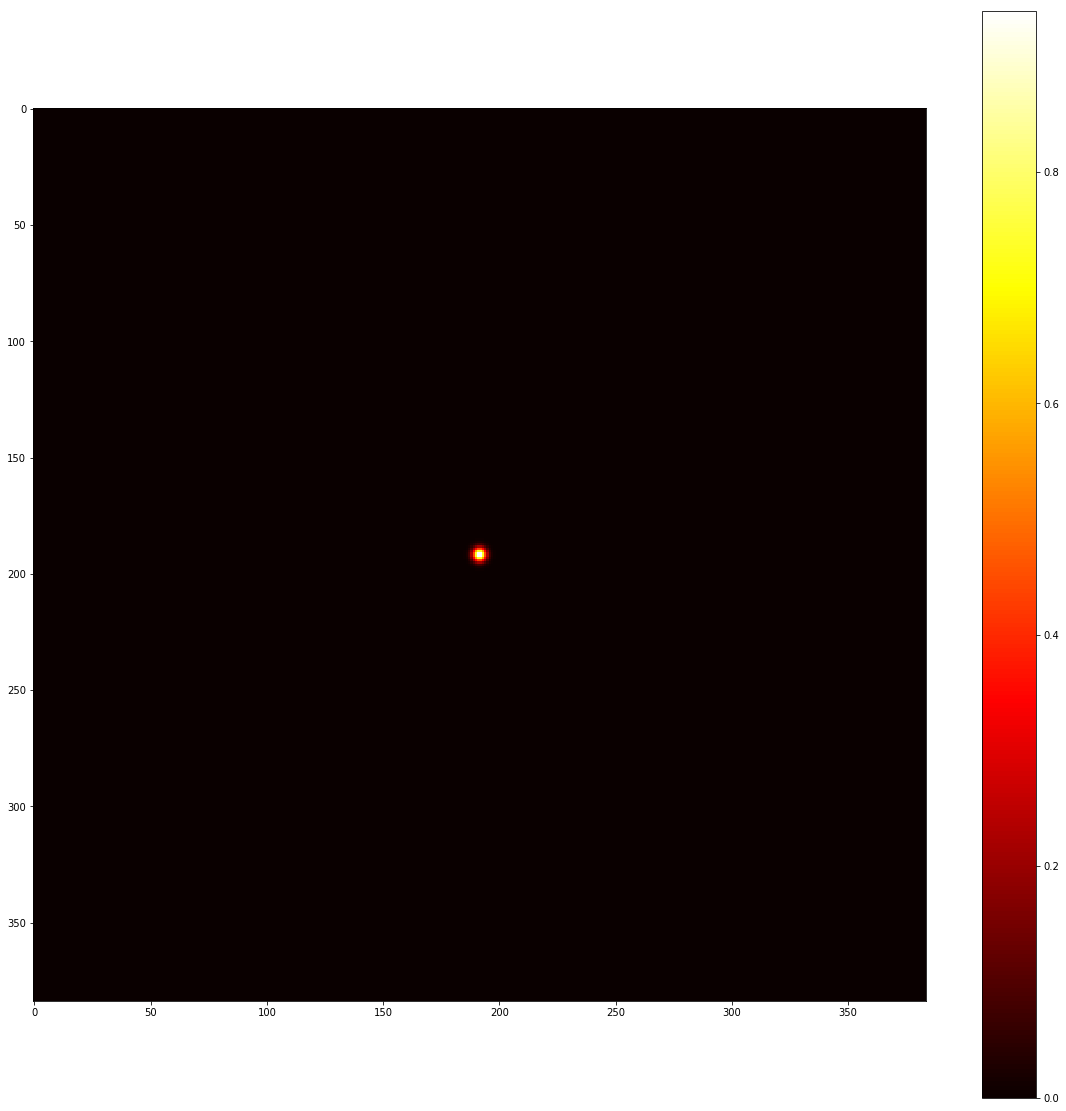

In [681]:
plt.figure(figsize = (20, 20))
plt.imshow(smooth_xy, cmap = "hot") ; plt.colorbar();

In [682]:
# 2 Convolutions 1D with smooth x and smooth y after
Ixy = Ix * Iy;
Ixy_smooth = convolve2d(convolve2d(Ixy, smooth_x, mode = "same"), smooth_y, mode = "same");
Iy_smooth = convolve2d(convolve2d(Iy, smooth_x, mode = "same"), smooth_y, mode = "same")
Ix_smooth = convolve2d(convolve2d(Ix, smooth_x, mode = "same"), smooth_y, mode = "same")

# Auto-correlation matrix

In [683]:
A = np.array([[Ix_smooth**2, Ixy_smooth], [Ixy_smooth, Iy_smooth**2]])
A.shape

(2, 2, 384, 384)

In [684]:
B = A[:, :, 100, 100];
B

array([[  1.65217837e-62,   5.76630800e-55],
       [  5.76630800e-55,   1.65217837e-62]])

In [685]:
Mc = np.linalg.det(B) - 0.04 * np.trace(B) ** 2
Mc

-3.3250307937562671e-109

In [686]:
np.linalg.eigvals(B)

array([  5.76630816e-55,  -5.76630783e-55])

In [687]:
C = A[:, :, 137, 222];
print (C)
np.linalg.eigvals(C)

[[  6.36748305e-25   8.90950144e-14]
 [  8.90950144e-14   7.93045240e+00]]


array([ 0.       ,  7.9304524])

In [688]:
np.linalg.det(A.T)[100, 100]

-3.3250307937562666e-109

In [689]:
np.linalg.eigvals(A).shape

(2, 2, 384)

In [690]:
D = A.copy()

In [691]:
Corner_response_eigs = np.linalg.eigvals(D.T)
Corner_response_Mc = np.linalg.det(D.T) - kappa * np.trace(D.T, axis1 = 2, axis2 = 3)**2
Corner_response_Mc = Corner_response_Mc.T 
print ("Shape of corner response : {}".format(Corner_response_Mc.shape))

Shape of corner response : (384, 384)


In [692]:
# Reponse above threshold and local maximum (8 neighbors) => detection
## Reponses below threshold * max are set to 0
Corner_response_Mc[Corner_response_Mc < threshold * Corner_response_Mc.max()] = 0
## Keep local maxima (in 3x3)
h, w = Corner_response_Mc.shape
detected_points = Corner_response_Mc.copy()
for i,j in np.ndindex(detected_points.shape):
    local_max = Corner_response_Mc[max(0, i - 1):min(i + 2, h),
                                   max(0, j - 1):min(j + 2, w)].max()
    if detected_points[i, j] == local_max:
        detected_points[max(0, i - 1):min(i + 2, h), max(0, j - 1):min(j + 2, w)].fill(0)
        detected_points[i, j] = local_max
    else:
        detected_points[i, j] = 0

In [693]:
print ("Total of detected points after thresholding : {}".format((Corner_response_Mc > 0).sum()))
print ("Total of detected points after local maxima cut : {}".format((detected_points > 0).sum()))

Total of detected points after thresholding : 646
Total of detected points after local maxima cut : 122


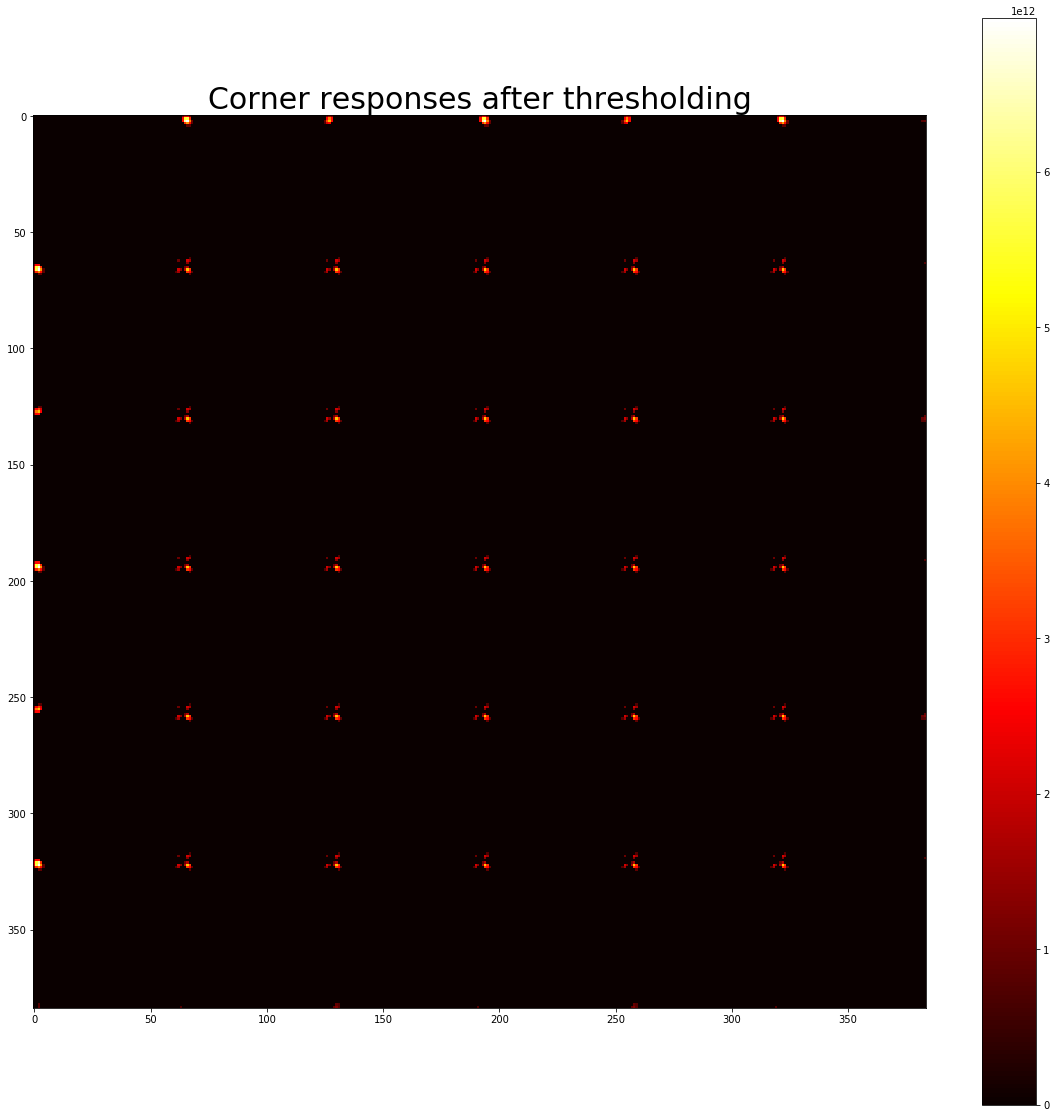

In [694]:
plt.figure(figsize = (20, 20));
plt.imshow(Corner_response_Mc, cmap = "hot") ; plt.colorbar();
plt.title("Corner responses after thresholding", fontsize = 30);

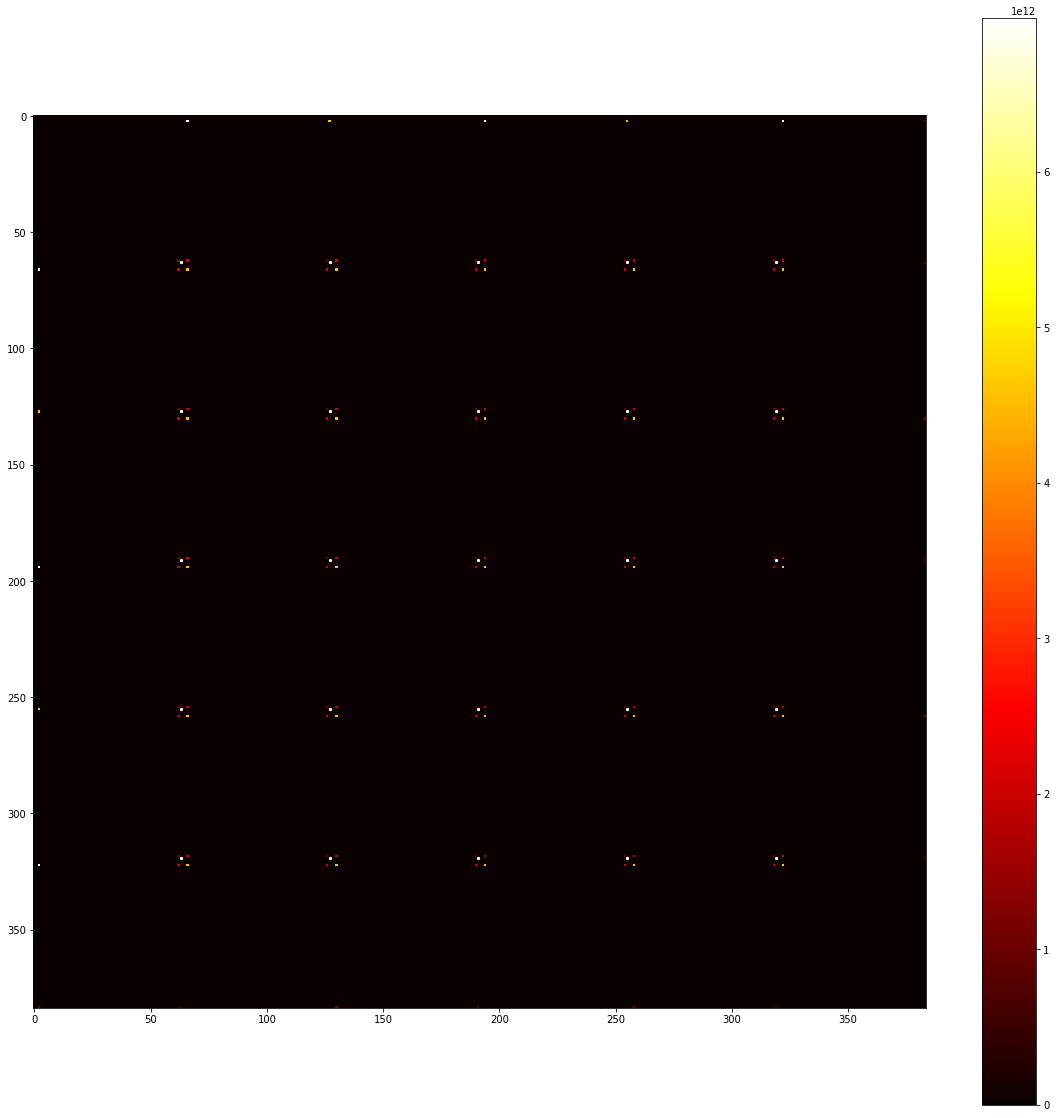

In [701]:
plt.figure(figsize = (20, 20));
plt.imshow(detected_points, cmap = "hot") ; plt.colorbar();
plt.scatter(chess_th[:, 0], chess_th[:, 1], color = 'white', marker= ".", s = 20);

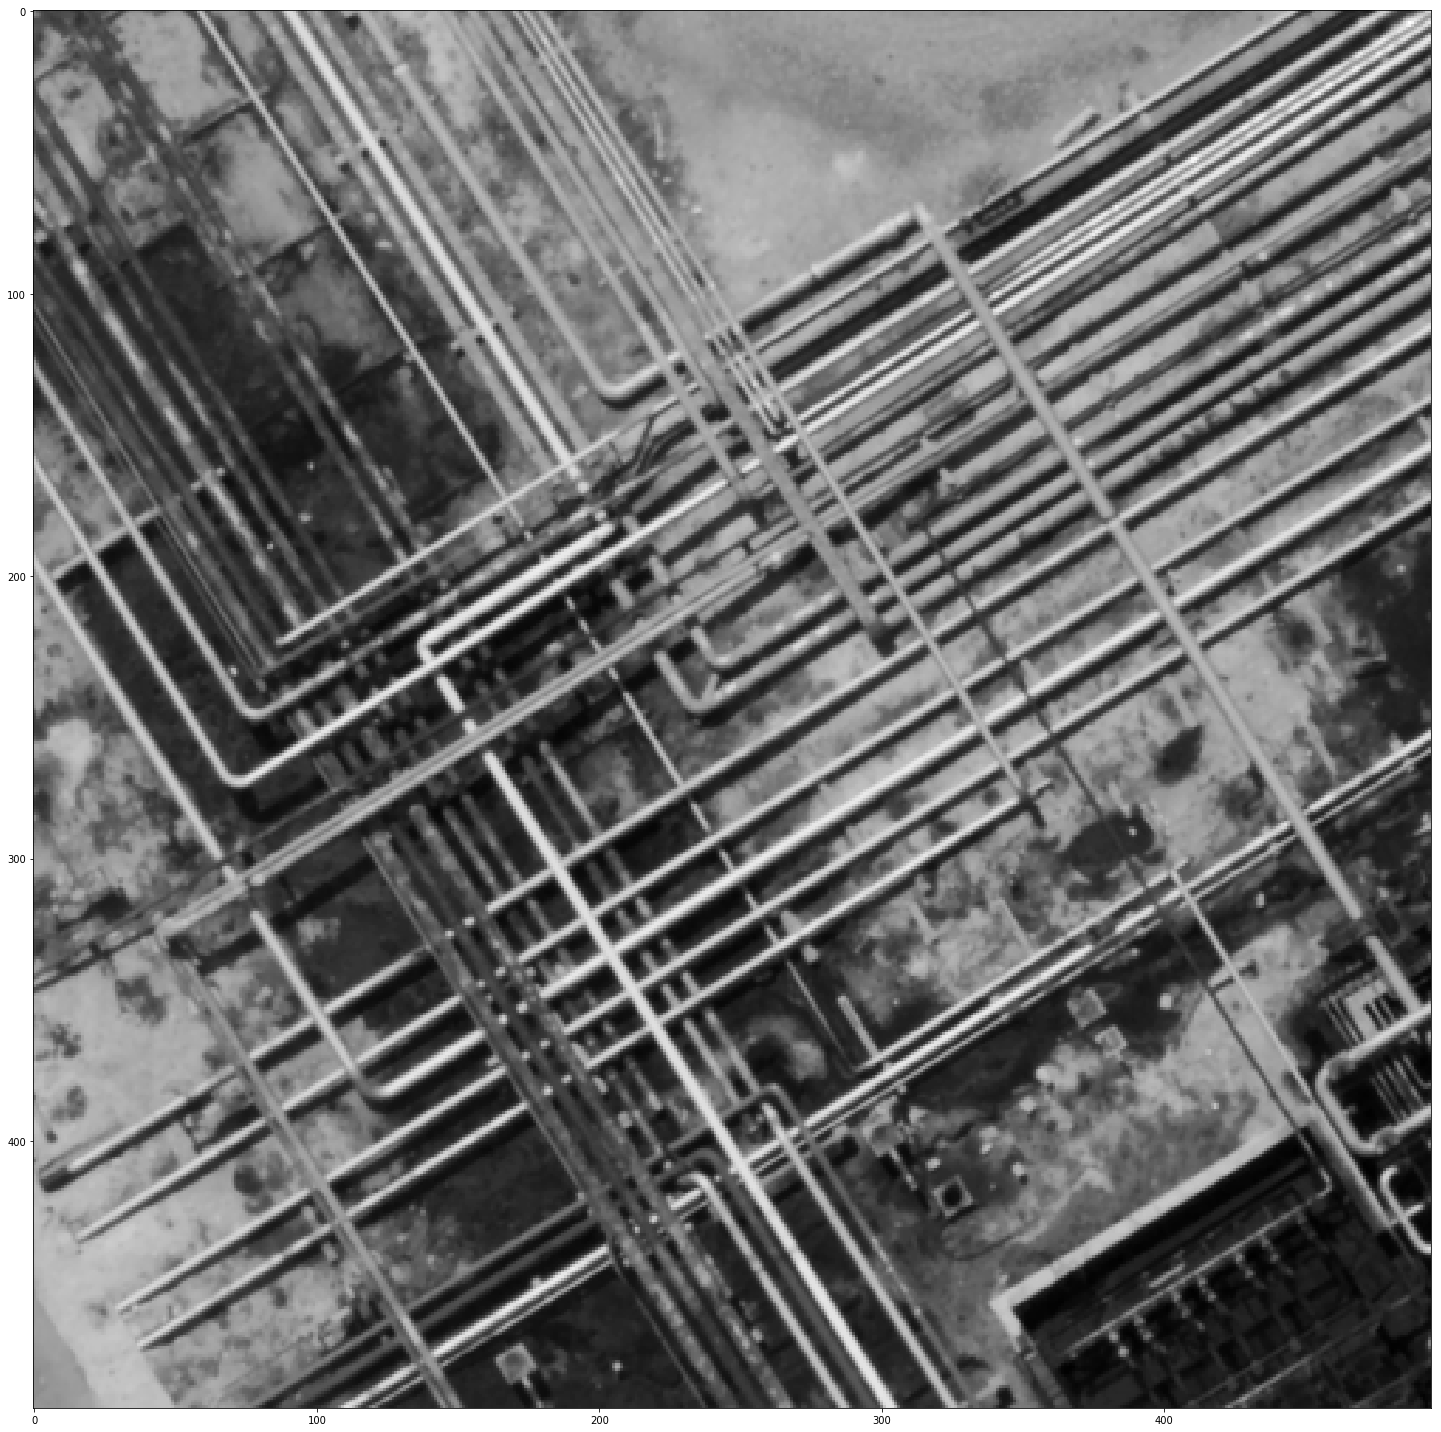

In [667]:
plt.figure(figsize = (20, 20));
imshow(bouc);

# Adaptative non-maximum suppression